# Examining FRIBDAQ Data: The Ion Chamber

This notebook demonstrates the algorithm in the point cloud phase used to analyze ion chamber data. Typically, AT-TPC data contains more than just the data produced by the AT-TPC itself. In particular, an upstream ion chamber is critical for selecting the beam of interest entering the AT-TPC. Without this, the data is polluted by reactions involving other beams than the species of interest. This data is typically handled by a separate DAQ called FRIB(NSCL)DAQ.  This notebook will demonstrate the analysis used by Spryal to extract the FRIBDAQ data.

First we load the relevant modules

In [1]:
from spyral.trace.frib_trace import FRIB_TRACE_LENGTH
from spyral.trace.frib_event import IC_COLUMN
from spyral.trace.trace_reader import create_reader
from spyral.core.run_stacks import form_run_string
from spyral import FribParameters, DetectorParameters, GetParameters

import numpy.random as random
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import mplcursors

%matplotlib widget

Now we load our configuration and workspace. While using this notebook one can also customize the configuration on the fly without modifying the acutal JSON file

In [ ]:
# Set some parameters
trace_data_path = Path("/Volumes/researchEXT/24Mg/run_24Mg/")


get_params = GetParameters(
    baseline_window_scale=20.0,
    peak_separation=50.0, #set to 5 in Zach's version 
    peak_prominence=20.0,
    peak_max_width=100.0, #changed from 50.0 to 100.0
    peak_threshold=100.0, #changed from 40.0 to 100.0
)

# frib_params = FribParameters(
#     baseline_window_scale=100.0,
#     peak_separation=50.0,
#     peak_prominence=20.0,
#     peak_max_width=500.0,
#     peak_threshold=100.0,
#     ic_delay_time_bucket=150, #was 1100 for 15C for 24 Mg must be lower than 196
#     ic_multiplicity=1,
# )

frib_params = FribParameters(
    baseline_window_scale=100.0,
    peak_separation=50.0,  #set to 5 in Zach's version 
    peak_prominence=30.0, #changed from 20.0 to 30.0
    peak_max_width=20.0, #changed from 500.0 to 20.0
    peak_threshold=300.0, #changed from 100.0 to 300.0
    ic_delay_time_bucket=150,
    ic_multiplicity=1,
)

det_params = DetectorParameters(
    magnetic_field=0,
    electric_field=9690,
    detector_length=1000.0,
    beam_region_radius=20.0,
    icromegas_time_bucket=91.98,
    window_time_bucket=469.21,
    get_frequency=6.25,
    garfield_file_path=Path("/path/to/some/garfield.txt"),
    do_garfield_correction=False,
)


Pick a run to inspect and load the reader

In [3]:
run_number = 30
trace_file_path = trace_data_path / f"{form_run_string(run_number)}.h5"
trace_reader = create_reader(trace_file_path, run_number)
if trace_reader is None:
    raise Exception("Couldn't read trace file!")

event_iterator = iter(trace_reader.event_range())
rng = random.default_rng()

### Analysis

Re-running the cells below this will walk through events in the file in order.

Now we select a specific event from the FRIBDAQ data. The event numbers here should match the event numbers in the GET data. By default a random event is selected, but it can be useful to hardcode the event to inspect specific behavior. We then retrieve the traces from the SIS3300 module (id 1903).

In [53]:
plt.close()
event_number = None
# Can always overwrite with hardcoded event number if needed
# event_number = 38537
if event_number is None:
    try:
        event_number = next(event_iterator)
    except StopIteration:
        raise Exception("You ran out of events (wow!) for this file. Open a new file.")
print(f'Event {event_number}')

event = trace_reader.read_event(event_number, get_params, frib_params, rng)
if event.frib is None:
    raise Exception("There is no FRIB data for this event!")
trace_data =  trace_reader.read_raw_frib_event(event_number)

Event 10
(512,) (8, 512)


First lets plot the raw trace for the ion  chamber

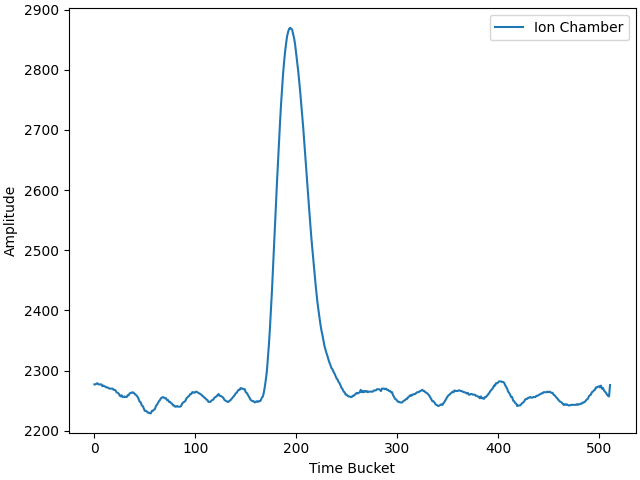

In [54]:
sample_range = np.arange(0, FRIB_TRACE_LENGTH)
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(sample_range, trace_data[:, IC_COLUMN], label="Ion Chamber")
ax.set_xlabel("Time Bucket")
ax.set_ylabel("Amplitude")
ax.legend()

Now we'll clean up those traces, removing the baseline, by passing the data to the FribEvent class. This will also identify peaks in the traces, which we'll label in the plot.

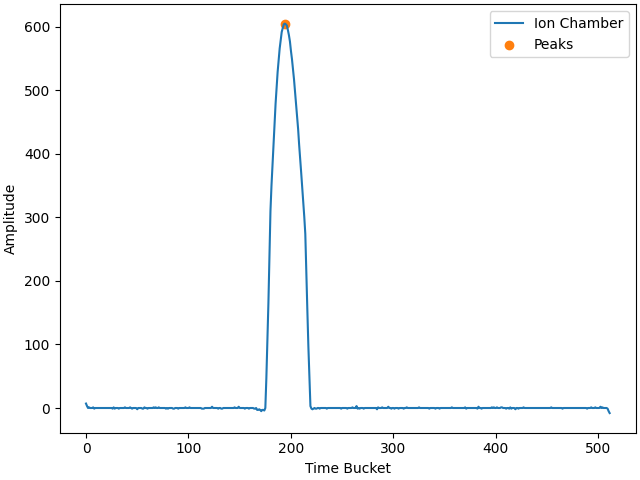

In [57]:
ic_cents = []
ic_amps = []
for peak in event.frib.get_ic_trace().peaks:
    ic_cents.append(peak.centroid)
    ic_amps.append(peak.amplitude)


sample_range = np.arange(0, FRIB_TRACE_LENGTH)
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(sample_range, event.frib.get_ic_trace().trace, label="Ion Chamber")
ax.scatter(ic_cents, ic_amps, c="C1", label="Peaks")
mplcursors.cursor()
ax.set_xlabel("Time Bucket")
ax.set_ylabel("Amplitude")
ax.legend()

Another important concept of the ion chamber signal is the triggering peak. See the diagram at the AT-TPC [webpage](https://attpc.github.io/hardware/attpc/) Since the ion chamber is delayed a fixed amount every event, in general, the position of the trigger should not vary much. By running through some events in this notebook, you can identify this position, and use the `ic_delay_time_bucket` paramter in the configuration. This sets a lower threshold (in time); the first peak past this threshold is taken as the trigger. As such, FribEvent has some methods to handle this, demonstrated below.

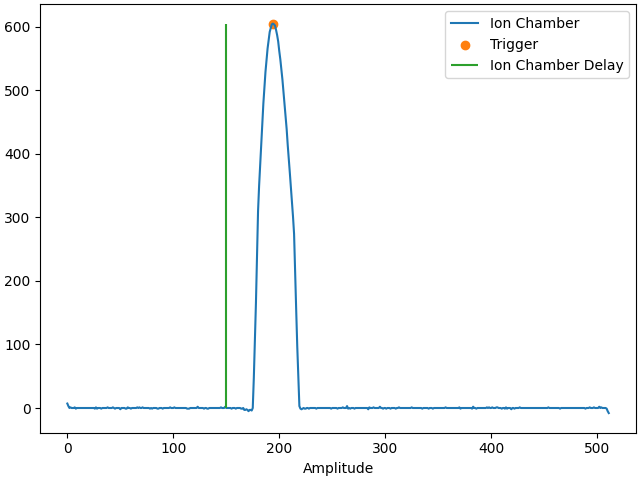

In [56]:
trigger = event.frib.get_triggering_ic_peak(frib_params)
if trigger is None:
    raise Exception("There is no trigger in this event! Uh Oh!")

sample_range = np.arange(0, FRIB_TRACE_LENGTH)
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(sample_range, event.frib.get_ic_trace().trace, label="Ion Chamber")
ax.scatter([trigger.centroid], [trigger.amplitude], c="C1", label="Trigger")
ax.vlines([frib_params.ic_delay_time_bucket], 0.0, trigger.amplitude, colors="C2", label="Ion Chamber Delay")
mplcursors.cursor()
ax.set_xlabel("Time Bucket")
ax.set_xlabel("Amplitude")
ax.legend()